In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline

data = pd.read_csv('emails.csv')

print(data.head())

                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1


In [5]:
print(data.describe())

              spam
count  5728.000000
mean      0.238827
std       0.426404
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


In [6]:
print(data.columns)

Index(['text', 'spam'], dtype='object')


In [7]:
def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
    return ' '.join(words)

data['processed_text'] = data['text'].apply(preprocess_text)
for i in range(3):  # Adjust the range based on the number of examples you want to print
    print("Original:", data['text'][i])
    print("Preprocessed:", data['processed_text'][i])
    print()

Original: Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability :

In [8]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['spam'], test_size=0.2, random_state=42)

# Build and train the model
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print(classification_report(y_test, predictions))

Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       856
           1       0.98      0.98      0.98       290

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



In [9]:
# Basic dataset statistics
print(data['spam'].value_counts())

spam
0    4360
1    1368
Name: count, dtype: int64


In [10]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[851   5]
 [  7 283]]


In [11]:
# Get feature names from CountVectorizer
feature_names = model.named_steps['countvectorizer'].get_feature_names_out()

# Get log probabilities from the trained Naive Bayes model
log_probabilities = model.named_steps['multinomialnb'].feature_log_prob_

# Create a dataframe of feature names and their log probabilities for each class
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'LogProbability_Spam': log_probabilities[1], 'LogProbability_NotSpam': log_probabilities[0]})

# Display the top words contributing to spam and non-spam predictions
print("Top words contributing to spam:")
print(feature_importance_df.sort_values(by='LogProbability_Spam', ascending=False).head(10))
print("\nTop words contributing to non-spam:")
print(feature_importance_df.sort_values(by='LogProbability_NotSpam', ascending=False).head(10))

Top words contributing to spam:
           Feature  LogProbability_Spam  LogProbability_NotSpam
25895      subject            -4.828210               -4.347068
4935           com            -5.359813               -5.032219
5058       company            -5.470713               -6.534127
8483         email            -5.481575               -6.337603
3501      business            -5.527872               -6.289627
13131  information            -5.581576               -6.029301
17225        money            -5.685023               -8.724871
15933         mail            -5.764587               -6.263495
18711          one            -5.815554               -6.083325
20237       please            -5.837581               -5.006771

Top words contributing to non-spam:
        Feature  LogProbability_Spam  LogProbability_NotSpam
8776      enron           -11.944604               -3.896092
8183        ect           -11.251457               -4.083503
25895   subject            -4.828210        

In [12]:
# Class imbalance ratio
class_imbalance_ratio = data['spam'].value_counts()[1] / data['spam'].value_counts()[0]
print(f"Class Imbalance Ratio: {class_imbalance_ratio:.2f}")

Class Imbalance Ratio: 0.31


In [13]:
# Add predictions to the test set
test_set_with_predictions = X_test.to_frame().assign(Predicted=predictions, Actual=y_test)

# Display misclassified samples
misclassified_samples = test_set_with_predictions[test_set_with_predictions['Predicted'] != test_set_with_predictions['Actual']]
print("Misclassified samples:")
print(misclassified_samples.head())

Misclassified samples:
                                         processed_text  Predicted  Actual
401   subject nymex invitation learn power trading p...          0       1
333   subject benachrichtung zum fehlgeschlagen dies...          0       1
1411  subject investment may concern keep receiving ...          1       0
712   subject wm subject dear guests explore turkey ...          0       1
79    subject join focus groups earn money la carte ...          0       1


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.98
Recall: 0.98
F1-Score: 0.98


In [15]:
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
print(metrics_df)

      Metric     Value
0   Accuracy  0.989529
1  Precision  0.982639
2     Recall  0.975862
3   F1-Score  0.979239


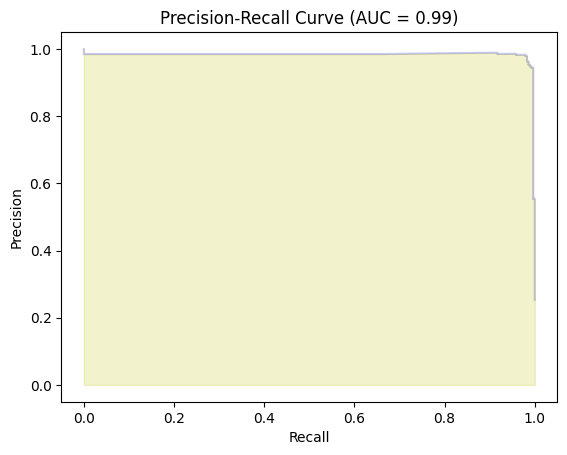

In [59]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='y')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(pr_auc))
plt.show()

C:\Users\Anush Pranav\AppData\Local\Temp\ipykernel_102324\3197161293.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='inferno')


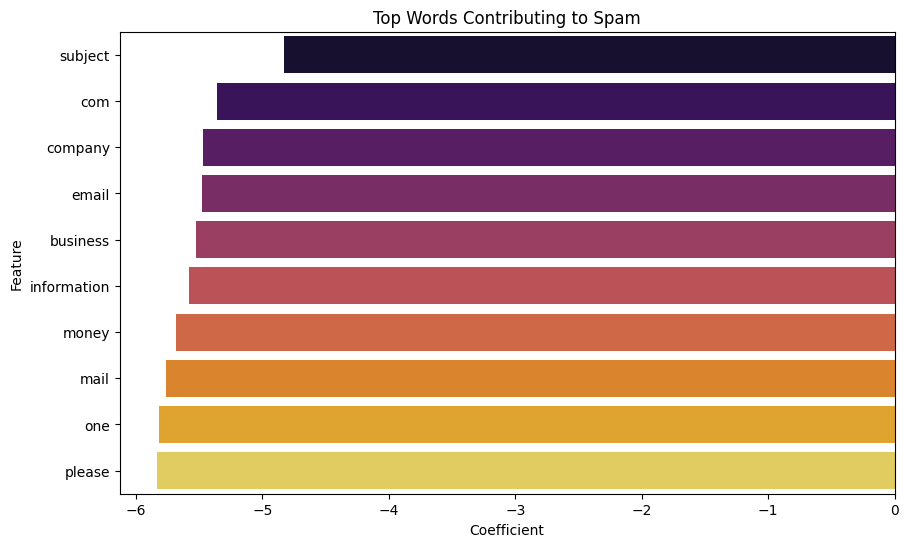

In [22]:
feature_names = model.named_steps['countvectorizer'].get_feature_names_out()
coefficients = model.named_steps['multinomialnb'].feature_log_prob_[1]  # Assuming binary classification (spam or not spam)

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
top_features = feature_importance_df.sort_values(by='Coefficient', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='inferno')
plt.title('Top Words Contributing to Spam')
plt.show()

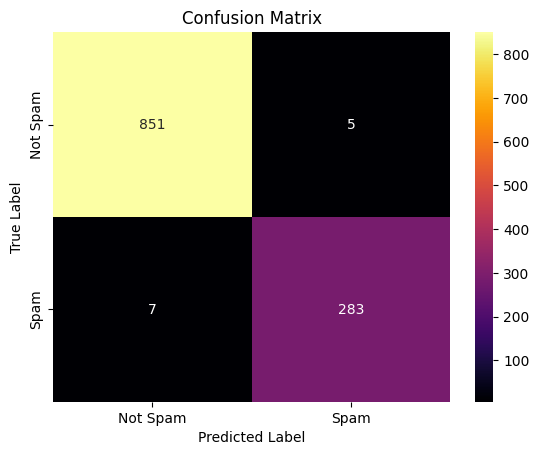

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

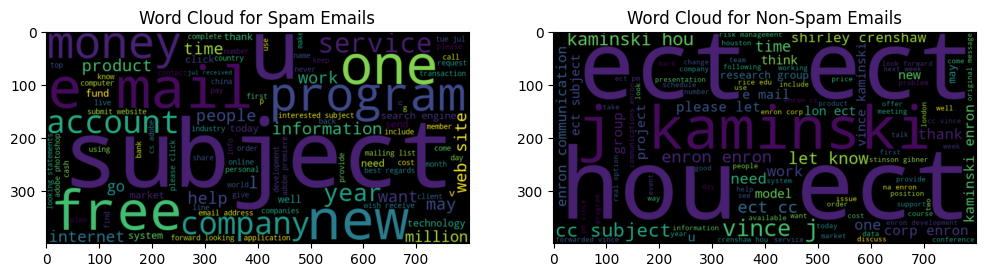

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_words = ' '.join(data[data['spam'] == 1]['processed_text'])
non_spam_words = ' '.join(data[data['spam'] == 0]['processed_text'])

# Word cloud for spam emails
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=800, height=400, random_state=42, max_words=100).generate(spam_words)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Word Cloud for Spam Emails')

# Word cloud for non-spam emails
plt.subplot(1, 2, 2)
wordcloud_non_spam = WordCloud(width=800, height=400, random_state=42, max_words=100).generate(non_spam_words)
plt.imshow(wordcloud_non_spam, interpolation='bilinear')
plt.title('Word Cloud for Non-Spam Emails')

plt.show()

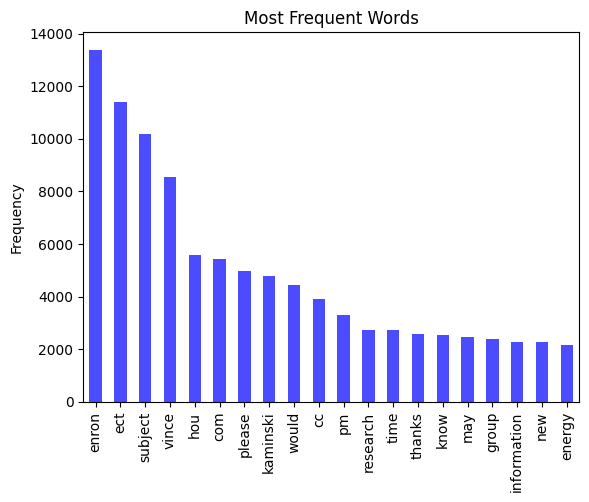

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

# Most frequent words bar plot
vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(data['processed_text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq.sum().sort_values(ascending=False).plot(kind='bar', color='blue', alpha=0.7)
plt.title('Most Frequent Words')
plt.ylabel('Frequency')
plt.show()

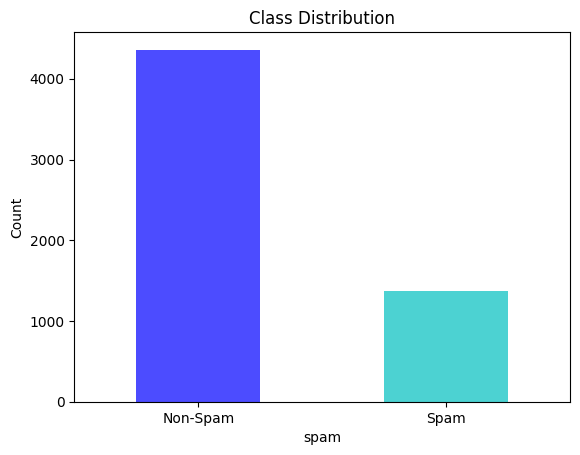

In [61]:
# Bar plot of class distribution
data['spam'].value_counts().plot(kind='bar', color=['b', 'c'], alpha=0.7)
plt.xticks([0, 1], ['Non-Spam', 'Spam'], rotation='horizontal')
plt.title('Class Distribution')
plt.ylabel('Count')
plt.show()

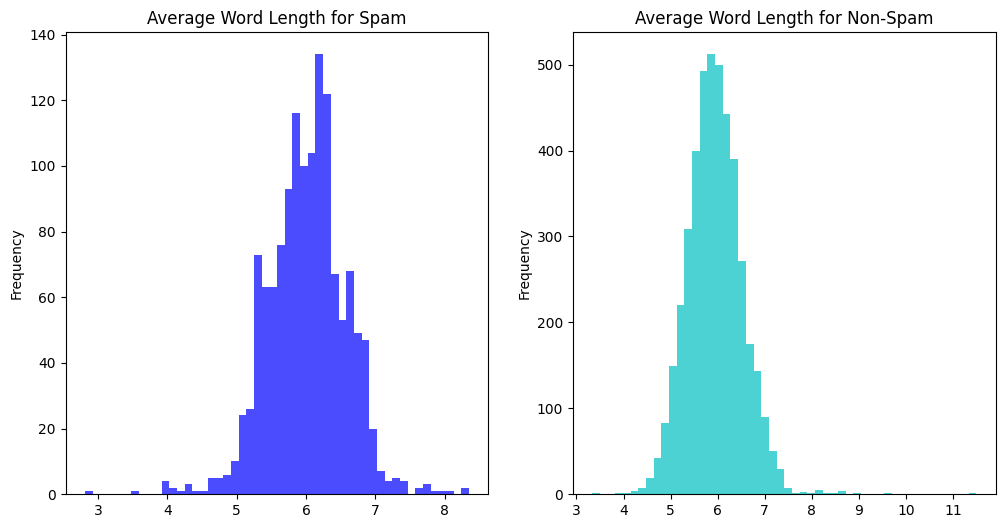

In [42]:
# Average word length
data['avg_word_length'] = data['processed_text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
data[data['spam'] == 1]['avg_word_length'].plot(kind='hist', bins=50, color='b', alpha=0.7)
plt.title('Average Word Length for Spam')

plt.subplot(1, 2, 2)
data[data['spam'] == 0]['avg_word_length'].plot(kind='hist', bins=50, color='c', alpha=0.7)
plt.title('Average Word Length for Non-Spam')

plt.show()

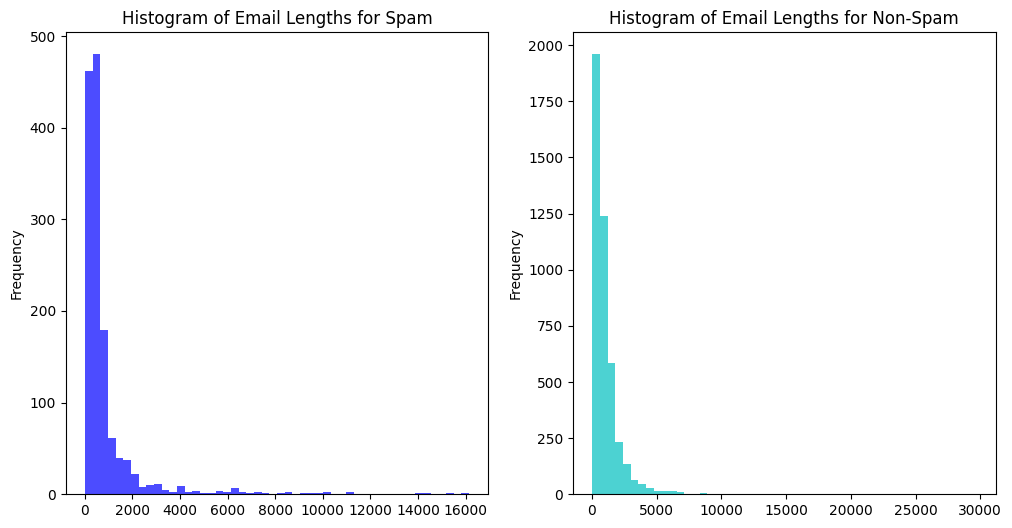

In [57]:
# Histogram of email lengths for spam and non-spam
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
data[data['spam'] == 1]['processed_text'].apply(len).plot(kind='hist', bins=50, color='b', alpha=0.7)
plt.title('Histogram of Email Lengths for Spam')

plt.subplot(1, 2, 2)
data[data['spam'] == 0]['processed_text'].apply(len).plot(kind='hist', bins=50, color='c', alpha=0.7)
plt.title('Histogram of Email Lengths for Non-Spam')

plt.show()

C:\Users\Anush Pranav\AppData\Local\Temp\ipykernel_102324\3741566422.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='spam', y='avg_word_length', data=data, palette='inferno')


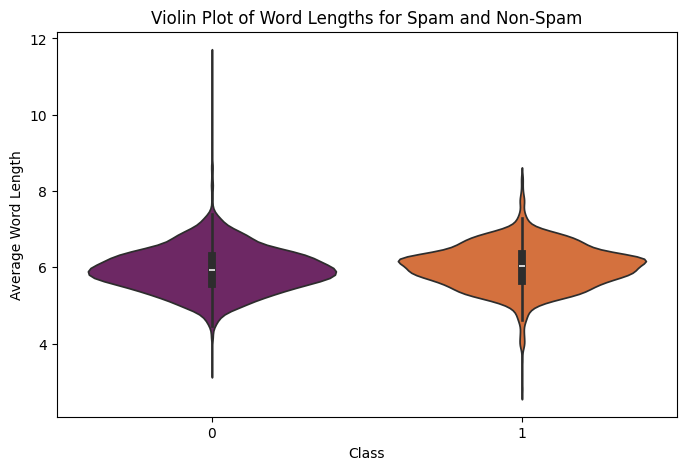

In [45]:
# Violin plot of word lengths
plt.figure(figsize=(8, 5))
sns.violinplot(x='spam', y='avg_word_length', data=data, palette='inferno')
plt.title('Violin Plot of Word Lengths for Spam and Non-Spam')
plt.xlabel('Class')
plt.ylabel('Average Word Length')
plt.show()

C:\Users\Anush Pranav\AppData\Local\Temp\ipykernel_102324\1415626134.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spam', y='avg_word_length', data=data, palette='inferno')


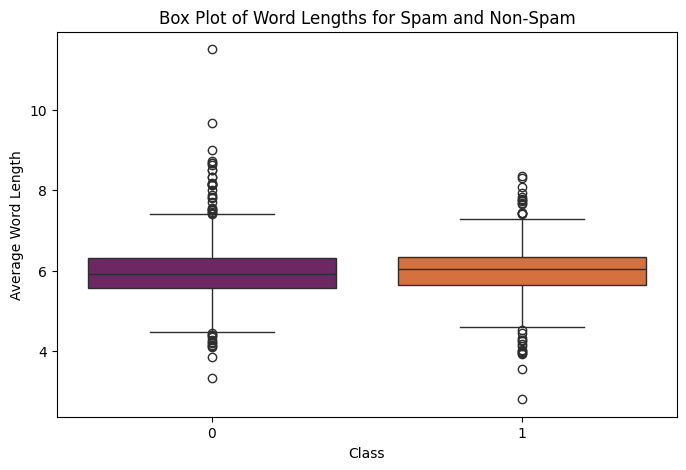

In [47]:
# Box plot of word lengths
plt.figure(figsize=(8, 5))
sns.boxplot(x='spam', y='avg_word_length', data=data, palette='inferno')
plt.title('Box Plot of Word Lengths for Spam and Non-Spam')
plt.xlabel('Class')
plt.ylabel('Average Word Length')
plt.show()

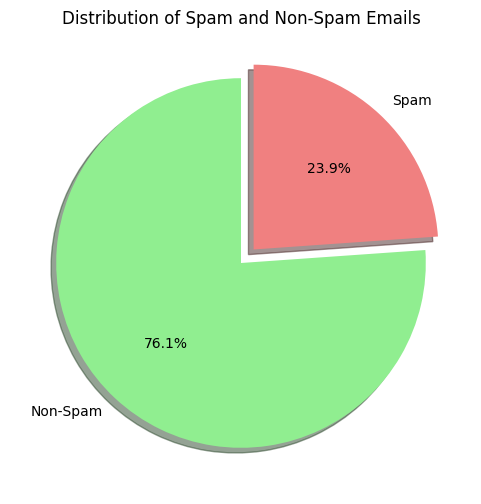

In [58]:
# Pie chart of spam and non-spam distribution
plt.figure(figsize=(6, 6))
labels = ['Non-Spam', 'Spam']
sizes = data['spam'].value_counts()
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.show()